<h1 style="font-weight:bold; text-align:center;">MOHAMMADREZA MOHAMMADHASHEMI 810100206</h1>
<h1 style="text-align:center;">CA5 - CNN</h1>

## **imporing the dataset to contents**

In [1]:
!gdown --id '1dp1AzTaXIQeGE58CqeO4UclplA28Q5C9'

'gdown' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
import zipfile

with zipfile.ZipFile('/content/AI-CA5-Dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')


FileNotFoundError: [Errno 2] No such file or directory: '/content/AI-CA5-Dataset.zip'

## Importing librarys

In [3]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import random
import cv2
import sys

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
def load_from_dataset (path , img_size_w , img_size_h):
  data = []
  for f in glob.iglob(path):
    img = cv2.imread(f , cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img,(img_size_w,img_size_h))
    data.append(img)
  return data

# Implementing subclass of dataset class as MRI class

In [6]:
class MRI(Dataset):
  def __init__(self):

    self.X_train, self.y_train, self.X_test, self.y_test = None, None, None, None

    self.mode = 'train'

    glioma_path = "./AI-CA5-Dataset/glioma/*.jpg"
    meningioma_path = "./AI-CA5-Dataset/meningioma/*.jpg"
    notumor_path = "./AI-CA5-Dataset/notumor/*.jpg"
    pituitary_path = "./AI-CA5-Dataset/pituitary/*.jpg"

    notumor = load_from_dataset (notumor_path , 224 , 224)
    glioma = load_from_dataset (glioma_path , 224 , 224)
    meningioma = load_from_dataset (meningioma_path , 224 , 224)
    pituitary = load_from_dataset (pituitary_path , 224 , 224)

    notumor = np.array(notumor , dtype=np.float32)
    glioma = np.array(glioma , dtype=np.float32)
    meningioma = np.array(meningioma , dtype=np.float32)
    pituitary = np.array(pituitary , dtype=np.float32)

    notumor_labels = np.zeros(notumor.shape[0], dtype=np.float32)
    glioma_labels = np.full(glioma.shape[0], 1.0)
    meningioma_labels = np.full(meningioma.shape[0], 2.0)
    pituitary_labels = np.full(pituitary.shape[0], 3.0)

    self.images = np.concatenate((notumor, glioma, meningioma, pituitary), axis=0)
    self.labels = np.concatenate((notumor_labels, glioma_labels, meningioma_labels, pituitary_labels))

  def train_val_split(self):
    self.X_train, self.X_test, self.y_train, self.y_test = \
    train_test_split(self.images, self.labels, test_size=0.20, random_state=42)

  def __len__(self):
    if self.mode == 'train':
      return self.X_train.shape[0]
    elif self.mode == 'val':
      return self.X_test.shape[0]

  def __getitem__(self, idx):
    if self.mode== 'train':
      sample = {'image': self.X_train[idx], 'label': self.y_train[idx]}

    elif self.mode== 'val':
      sample = {'image': self.X_test[idx], 'label': self.y_test[idx]}

    image = torch.tensor(sample['image'], dtype=torch.float32)
    label = torch.tensor(sample['label'], dtype=torch.float32)
    return {'image': image, 'label': label}

  def normalize(self):
    self.images = self.images/255.0

# Normalization :
Normalization is a pre-processing technique used to standardize data. In the context of images, normalization typically involves adjusting the pixel values so that they fall within a certain range, often between 0 and 1 or -1 and 1. This is usually done by subtracting the mean and dividing by the standard deviation.

The impact of normalization on the pixels of images is that it changes their scale. This can make the image data more suitable for processing by a Convolutional Neural Network (CNN).
However, in this project, we limited ourselves to dividing each value by 255 for normalization

In [7]:
mri_dataset = MRI()
mri_dataset.normalize()
mri_dataset.train_val_split()

# Instantiate DataLoaders

In [8]:
train_dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)

# Model Architecture :
## GoogLeNet / InceptionNet
### Article : https://arxiv.org/abs/1409.4842

In general, various architectures such as LeNet-5 - AlexNet - VGGNet were introduced in the early 2010-2020 decade, which provided acceptable performance in photo classification problems.
In 2014, the GoogLeNet model was presented, which made a significant change in the structure of the convolutional network. In this model, the RELU activation function is used.
One of the most important methods in this model that makes the model perform better is the ability to use kernels of different sizes.

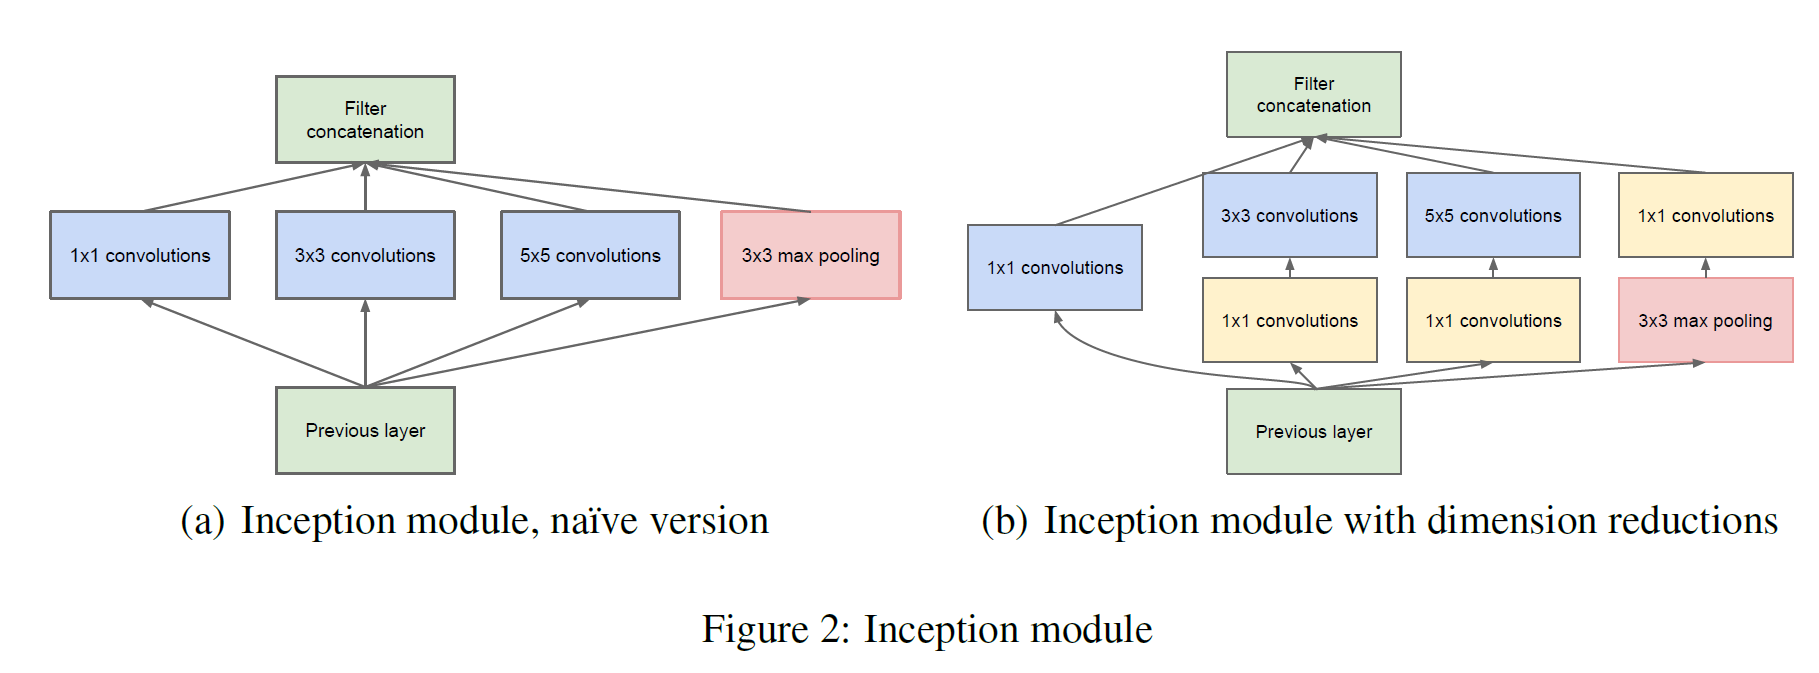

As can be seen in the figure above, convolutions with kernel sizes of 1*1 are used in order to reduce the number of kernels, for example 100 kernels are entered and 50 kernels are output from where the calculation of 5x5 kernels and even kernels 3x3 in the scale of CNNs can be costly, so in each layer according to the picture, we will have a small number of 5x5 filters, a larger number of 3x3 filters, and a number of pooling filters that allow us to learn their specified weights. It allows the use of kernels of different sizes

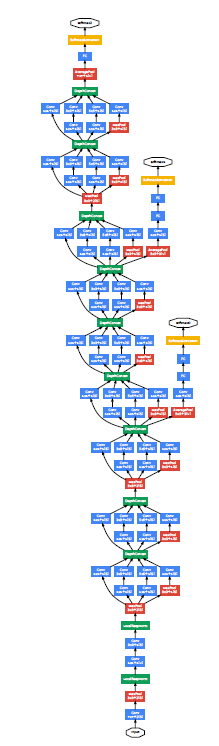

Above you can see the graph of the layers of this model

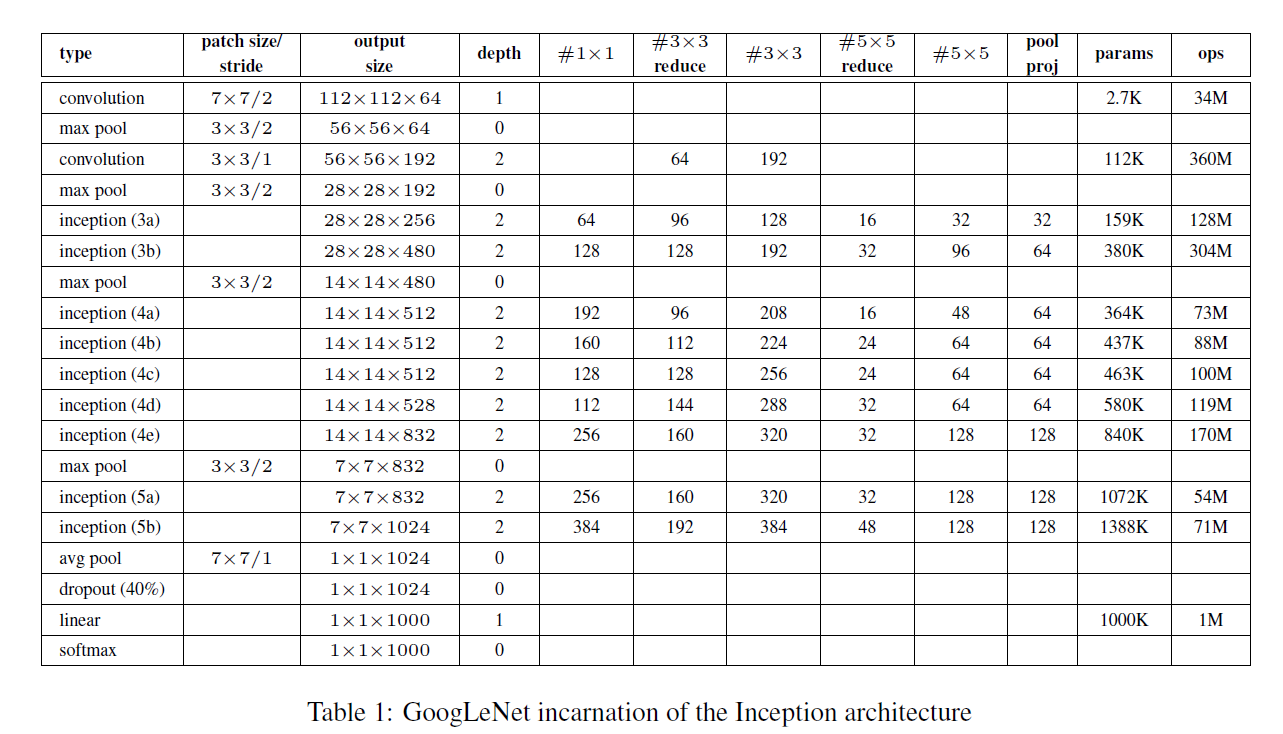

Above is the table that we have given in the article of the sizes and structure of this CNN, the inceptions were actually discussed in the photos above, which we will skip after explaining again. Another important thing that can be seen in this table and general graph is the existence of two It is a sub-branch leading to softmax or InceptionAux, which we will check its use.
vanishing gradient problem is one of the main problems in the learning process of a CNN, because in deep networks, in the backward process of learning, the loss calculated after passing through several layers becomes very small and increases the convergence time of the algorithm to optimal conditions, but the addition of this branch which are only active in the model training process, helps us to calculate 2 additional losses with the help of these outputs, and as a result of the sum of these 3 calculated loss values, we can see a higher effect in our network.

The output size of a convolutional layer can be calculated using the following formula:

$$
\text{{Output size}} = \left\lfloor \frac{{\text{{Input size}} - \text{{Filter size}} + 2 \times \text{{Padding}}}}{{\text{{Stride}}}} \right\rfloor + 1
$$

Where:
- **Input size** is the size (width or height) of the input.
- **Filter size** is the size (width or height) of the filter (also known as the kernel) used in the convolution.
- **Padding** is the number of pixels added to the input along the width and height.
- **Stride** is the number of pixels by which the filter is moved across the input.


Also, with the help of the above formula, all the transitions and sizes in the table can be proved, which can be checked

As some of the loss functions available in pytorch, we can mention Mean Squared Error (MSE) - Cross-Entropy Loss and Hinge Loss, each of which has its own functions, for example, MSE is more useful in regression tasks and Hinge Loss functions. And Cross-Entropy Loss has a better performance for classification problems, as Cross-Entropy Loss has a better performance in unbalanced datasets, in this project we have used this function to train our model.

## ADAM VS SDG :
SGD is an iterative method for optimizing an objective function with suitable smoothness properties. It can be regarded as a stochastic approximation of gradient descent optimization, since it replaces the actual gradient (calculated from the entire data set) by an estimate thereof (calculated from a randomly selected subset of the data). This reduces the computational burden, achieving faster iterations in exchange for a lower convergence rate.

The primary goal of SGD is to identify the model parameters that provide the maximum accuracy on both training and test datasets. In SGD, instead of using the entire dataset for each iteration, only a single random training example (or a small batch) is selected to calculate the gradient and update the model parameters.

Now, let’s move on to Adam Optimizer:

Adam is an adaptive optimization algorithm used for training machine-learning models. It uses the history of mini-batch gradients to find the direction of its update steps and tune its learning rates.

Adam combines the advantages of two other extensions of SGD: Momentum and RMSProp. Momentum accelerates the training process by taking into consideration the ‘exponentially weighted average’ of the gradients. RMSProp is an adaptive learning algorithm that tries to improve AdaGrad by taking the ‘exponential moving average.

## BATCH SIZE :
the batch size is a hyperparameter in machine learning that defines the number of samples to work through before updating the internal model parameters. It’s one of the most important hyperparameters in machine learning and can significantly impact your model’s performance1.
The choice of batch size can have a significant impact on your model’s performance. Larger batch sizes can lead to faster training, but also to a higher generalization error. On the other hand, smaller batch sizes can lead to a lower generalization error, but the model might take longer to train.

## You can download trained model after 100 epochs in the link bellow :
https://drive.google.com/file/d/1R5JX7KudwqyNVS5n4CoQzIBVRfjN5bAM/view?usp=drive_link

## Batch Normalization And Dropout :
Batch Normalization is a technique used in deep learning to accelerate training speed and improve accuracy. It works by standardizing the outputs of hidden units across an entire batch. The standardization process consists of multiplication and addition. This can be thought of as injecting the ‘correct noise’ needed to standardize hidden unit outputs across a batch, and although it won’t be as strong of a regularizing effect as actual uniform/gaussian random noise, it still has a minor regularizing effect on top of the benefit of speeding up learning.

Dropout is a regularization technique used in neural networks to prevent overfitting. It works by randomly deactivating a set of neurons for each training iteration. This makes it much harder for the network to learn spurious patterns in the training data. Instead, it has to search for broad, general patterns, whose weight patterns tend to be more robust.

In the model implemented below, we used both methods, which can be seen in the code and are also explained in the article, and their parameters are implemented based on the article.

In [9]:
from torch import nn

class GoogLeNet(nn.Module):
  def __init__(self, aux_logits=True, num_classes=4):
    super(GoogLeNet, self).__init__()
    assert aux_logits == True or aux_logits == False
    self.aux_logits = aux_logits

    self.conv1 = conv_block(
        in_channels=1,
        out_channels=64,
        kernel_size=7,
        stride=2,
        padding=3,
    )

    self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    self.conv2 = conv_block(64, 192, kernel_size=3, stride=1, padding=1)
    self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    # In this order: in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1pool
    self.inception3a = Inception_block(192, 64, 96, 128, 16, 32, 32)
    self.inception3b = Inception_block(256, 128, 128, 192, 32, 96, 64)
    self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    self.inception4a = Inception_block(480, 192, 96, 208, 16, 48, 64)
    self.inception4b = Inception_block(512, 160, 112, 224, 24, 64, 64)
    self.inception4c = Inception_block(512, 128, 128, 256, 24, 64, 64)
    self.inception4d = Inception_block(512, 112, 144, 288, 32, 64, 64)
    self.inception4e = Inception_block(528, 256, 160, 320, 32, 128, 128)
    self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    self.inception5a = Inception_block(832, 256, 160, 320, 32, 128, 128)
    self.inception5b = Inception_block(832, 384, 192, 384, 48, 128, 128)

    self.avgpool = nn.AvgPool2d(kernel_size=7, stride=1)
    self.dropout = nn.Dropout(p=0.4)
    self.fc1 = nn.Linear(1024, num_classes)

    if self.aux_logits:
      self.aux1 = InceptionAux(512, num_classes)
      self.aux2 = InceptionAux(528, num_classes)
    else:
      self.aux1 = self.aux2 = None

  def forward(self, x , reg_flag):
    x = self.conv1(x)
    x = self.maxpool1(x)
    x = self.conv2(x)
    x = self.maxpool2(x)

    x = self.inception3a(x)
    x = self.inception3b(x)
    x = self.maxpool3(x)

    x = self.inception4a(x)

    # Auxiliary Softmax classifier 1
    if self.aux_logits and self.training and reg_flag:
      aux1 = self.aux1(x)

    x = self.inception4b(x)
    x = self.inception4c(x)
    x = self.inception4d(x)

    # Auxiliary Softmax classifier 2
    if self.aux_logits and self.training and reg_flag:
      aux2 = self.aux2(x)

    x = self.inception4e(x)
    x = self.maxpool4(x)
    x = self.inception5a(x)
    x = self.inception5b(x)
    x = self.avgpool(x)
    x = x.reshape(x.shape[0], -1)
    x = self.dropout(x)
    x = self.fc1(x)

    if self.aux_logits and self.training and reg_flag:
      return aux1, aux2, x
    else:
      return x


class Inception_block(nn.Module):
  def __init__(
      self, in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1pool
  ):
    super(Inception_block, self).__init__()
    self.branch1 = conv_block(in_channels, out_1x1, kernel_size=1)

    self.branch2 = nn.Sequential(
      conv_block(in_channels, red_3x3, kernel_size=1),
      conv_block(red_3x3, out_3x3, kernel_size=(3, 3), padding=1),
    )

    self.branch3 = nn.Sequential(
      conv_block(in_channels, red_5x5, kernel_size=1),
      conv_block(red_5x5, out_5x5, kernel_size=5, padding=2),
    )

    self.branch4 = nn.Sequential(
      nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
      conv_block(in_channels, out_1x1pool, kernel_size=1),
    )

  def forward(self, x):
    return torch.cat(
      [self.branch1(x), self.branch2(x), self.branch3(x), self.branch4(x)], 1
    )


class InceptionAux(nn.Module):
  def __init__(self, in_channels, num_classes):
    super(InceptionAux, self).__init__()
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(p=0.7)
    self.pool = nn.AvgPool2d(kernel_size=5, stride=3)
    self.conv = conv_block(in_channels, 128, kernel_size=1)
    self.fc1 = nn.Linear(2048, 1024)
    self.fc2 = nn.Linear(1024, num_classes)

  def forward(self, x):
    x = self.pool(x)
    x = self.conv(x)
    x = x.reshape(x.shape[0], -1)
    x = self.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)
    return x


class conv_block(nn.Module):
  def __init__(self, in_channels, out_channels, **kwargs):
    super(conv_block, self).__init__()
    self.relu = nn.ReLU()
    self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
    self.batchnorm = nn.BatchNorm2d(out_channels)

  def forward(self, x):
    return self.relu(self.batchnorm(self.conv(x)))



In [10]:
from torch import optim
from tqdm import tqdm

In [11]:
# Hyperparameters
in_channels = 1
num_classes = 4
learning_rate = 3e-4 # karpathy's constant
batch_size = 64
num_epochs = 100

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)  # Should print "cuda" if a GPU is available


model = GoogLeNet(num_classes=num_classes).to(device=device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10, verbose=True)

for epoch in range(num_epochs):
  mri_dataset.mode = 'train'
  model.train()
  losses = []
  loop = tqdm(enumerate(train_dataloader) , total = len(train_dataloader) )
  whole_loss = 0
  correct_predictions = 0
  total_predictions = 0
  for batch_idx, sample in loop :
    data = sample['image']
    targets = sample['label'].long()
    data = data.unsqueeze(1)
    data = data.to(device=device)
    targets = targets.to(device=device)
    # forward
    outputs = model(data, True)
    if isinstance(outputs, tuple):
        loss1 = criterion(outputs[0], targets)
        loss2 = criterion(outputs[1], targets)
        loss3 = criterion(outputs[2], targets)
        loss = loss1 + loss2 + loss3
    else:
        loss = criterion(outputs, targets)
    losses.append(loss.item())

    whole_loss += abs(loss.item())
    _, predicted = torch.max(outputs[2], 1)
    total_predictions += targets.size(0)
    correct_predictions += (predicted == targets).sum().item()
    accuracy = 100.0 * correct_predictions / total_predictions
    # backward
    optimizer.zero_grad()
    loss.backward()
    # gradient descent or adam step
    optimizer.step()
    loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
    loop.set_postfix(loss=whole_loss , acc = accuracy)

  mean_loss = sum(losses) / len(losses)
  mean_loss = round(mean_loss, 2)
  scheduler.step(mean_loss)

cuda


e:\anaco\envs\GPU2\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch [9/100]:  76%|███████▌  | 25/33 [00:06<00:01,  4.13it/s, acc=95.4, loss=7.64]


KeyboardInterrupt: 

In [ ]:
num_correct = 0
num_samples = 0
model.eval()
mri_dataset.mode = 'val'
with torch.no_grad():
  for D in test_dataloader:
    data = D['image']
    data = data.unsqueeze(1).to(device=device)
    targets = D['label'].to(device=device)
    scores = model(data, True)
    _, predictions = scores.max(1)
    num_correct += (predictions == targets).sum()
    num_samples += predictions.size(0)

  print(f"On {num_samples} samples got {num_correct} corrects and the accuracy is : {(num_correct / num_samples)*100:.2f}")


On 263 samples got 251 corrects and the accuracy is : 95.44


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
model_save_name = 'model.pt'
path = F"/content/gdrive/My Drive/{model_save_name}"
torch.save(model.state_dict(), path)


Mounted at /content/gdrive


# Loading trained model
### In TA session load the model bellow and do the test on it


In [ ]:
model_save_name = 'model.pt'
path = F"/content/gdrive/My Drive/{model_save_name}"
model.load_state_dict(torch.load(path))

num_correct = 0
num_samples = 0
model.eval()
mri_dataset.mode = 'val'
with torch.no_grad():
  for D in test_dataloader:
    data = D['image']
    data = data.unsqueeze(1).to(device=device)
    targets = D['label'].to(device=device)
    scores = model(data, True)
    _, predictions = scores.max(1)
    num_correct += (predictions == targets).sum()
    num_samples += predictions.size(0)

  print(f"On {num_samples} samples got {num_correct} corrects and the accuracy is : {(num_correct / num_samples)*100:.2f}")

On 263 samples got 246 corrects and the accuracy is : 93.54


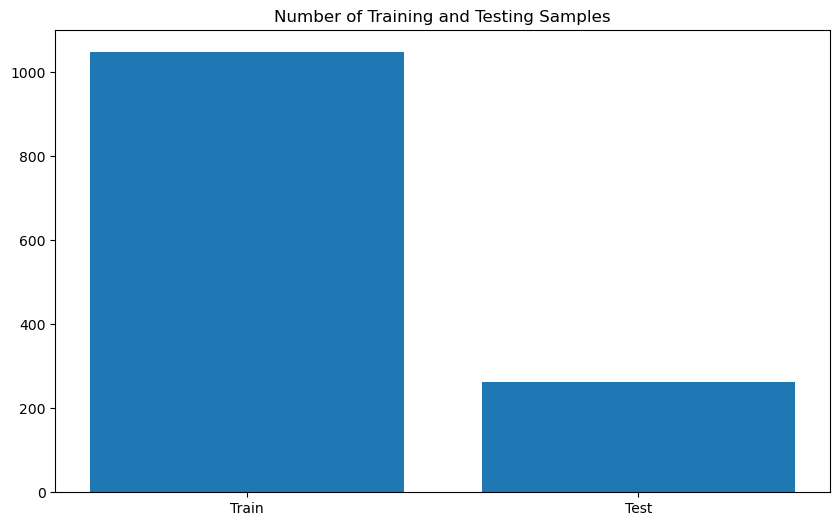

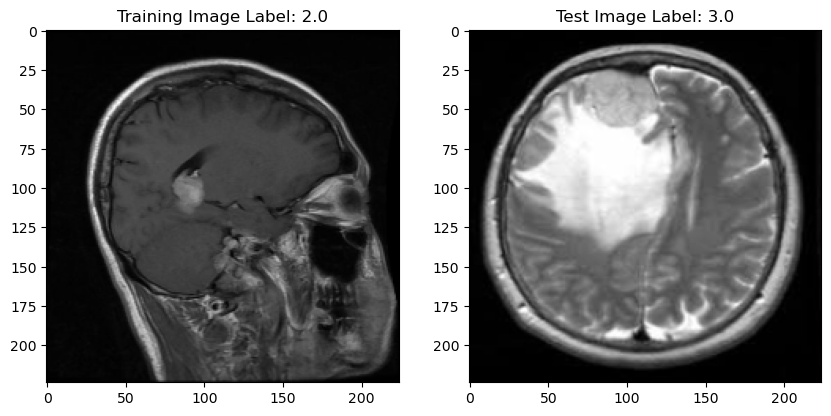

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(['Train', 'Test'], [len(mri_dataset.X_train), len(mri_dataset.X_test)])
plt.title('Number of Training and Testing Samples')
plt.show()

random_idx1 = np.random.randint(len(mri_dataset.X_train))
random_idx2 = np.random.randint(len(mri_dataset.X_test))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axes[0].imshow(mri_dataset.X_train[random_idx1], cmap='gray')
axes[0].set_title(f'Training Image Label: {mri_dataset.y_train[random_idx1]}')

axes[1].imshow(mri_dataset.X_test[random_idx2], cmap='gray')
axes[1].set_title(f'Test Image Label: {mri_dataset.y_train[random_idx2]}')

plt.show()


cuda


Epoch [1/50]: 100%|██████████| 33/33 [00:07<00:00,  4.40it/s, acc=64.5, loss=87.5]


Test Loss: 17.081756114959717, Test Accuracy: 23.574144486692017


Epoch [2/50]: 100%|██████████| 33/33 [00:07<00:00,  4.40it/s, acc=78.9, loss=54.2]


Test Loss: 13.548486590385437, Test Accuracy: 49.80988593155894


Epoch [3/50]: 100%|██████████| 33/33 [00:07<00:00,  4.40it/s, acc=80.7, loss=47.4]


Test Loss: 3.743095502257347, Test Accuracy: 85.55133079847909


Epoch [4/50]: 100%|██████████| 33/33 [00:07<00:00,  4.22it/s, acc=83.7, loss=41.4]


Test Loss: 9.36337986588478, Test Accuracy: 56.27376425855513


Epoch [5/50]: 100%|██████████| 33/33 [00:07<00:00,  4.19it/s, acc=89, loss=28.9]  


Test Loss: 12.95704984664917, Test Accuracy: 60.456273764258555


Epoch [6/50]: 100%|██████████| 33/33 [00:07<00:00,  4.26it/s, acc=90.6, loss=22]  


Test Loss: 3.1448561996221542, Test Accuracy: 85.93155893536121


Epoch [7/50]: 100%|██████████| 33/33 [00:07<00:00,  4.22it/s, acc=94.4, loss=17]  


Test Loss: 3.2282398492097855, Test Accuracy: 87.83269961977186


Epoch [8/50]: 100%|██████████| 33/33 [00:07<00:00,  4.26it/s, acc=94.7, loss=14.6]


Test Loss: 9.690804034471512, Test Accuracy: 75.66539923954373


Epoch [9/50]: 100%|██████████| 33/33 [00:07<00:00,  4.23it/s, acc=94.8, loss=12.8]


Test Loss: 3.1227555200457573, Test Accuracy: 87.83269961977186


Epoch [10/50]: 100%|██████████| 33/33 [00:08<00:00,  3.94it/s, acc=95.2, loss=16.2]


Test Loss: 9.862203389406204, Test Accuracy: 68.8212927756654


Epoch [11/50]: 100%|██████████| 33/33 [00:08<00:00,  4.00it/s, acc=94.1, loss=15.3]


Test Loss: 12.972540721297264, Test Accuracy: 61.97718631178707


Epoch [12/50]: 100%|██████████| 33/33 [00:07<00:00,  4.18it/s, acc=97.5, loss=6.49]


Test Loss: 2.7393980622291565, Test Accuracy: 90.8745247148289


Epoch [13/50]: 100%|██████████| 33/33 [00:07<00:00,  4.21it/s, acc=98.6, loss=4.79] 


Test Loss: 3.7994785010814667, Test Accuracy: 86.31178707224335


Epoch [14/50]: 100%|██████████| 33/33 [00:07<00:00,  4.18it/s, acc=96.4, loss=9.56]


Test Loss: 8.620059102773666, Test Accuracy: 77.9467680608365


Epoch [15/50]: 100%|██████████| 33/33 [00:07<00:00,  4.14it/s, acc=98.7, loss=4.86] 


Test Loss: 5.35390043258667, Test Accuracy: 83.65019011406844


Epoch [16/50]: 100%|██████████| 33/33 [00:07<00:00,  4.22it/s, acc=98.4, loss=3.27]


Test Loss: 4.2029842138290405, Test Accuracy: 86.69201520912547


Epoch [17/50]: 100%|██████████| 33/33 [00:07<00:00,  4.23it/s, acc=99.1, loss=2.65] 


Test Loss: 3.9082926362752914, Test Accuracy: 87.45247148288973


Epoch [18/50]: 100%|██████████| 33/33 [00:07<00:00,  4.23it/s, acc=99.4, loss=2.35] 


Test Loss: 3.3091908544301987, Test Accuracy: 87.83269961977186


Epoch [19/50]: 100%|██████████| 33/33 [00:07<00:00,  4.16it/s, acc=98.3, loss=3.86] 


Test Loss: 7.138828575029038, Test Accuracy: 79.84790874524715


Epoch [20/50]: 100%|██████████| 33/33 [00:07<00:00,  4.21it/s, acc=98.6, loss=3.53]


Test Loss: 5.9463168531656265, Test Accuracy: 85.93155893536121


Epoch [21/50]: 100%|██████████| 33/33 [00:07<00:00,  4.23it/s, acc=98.8, loss=3.69] 


Test Loss: 6.982341557741165, Test Accuracy: 79.08745247148289


Epoch [22/50]: 100%|██████████| 33/33 [00:07<00:00,  4.29it/s, acc=96.4, loss=8.06]


Test Loss: 17.496617555618286, Test Accuracy: 59.31558935361217


Epoch [23/50]: 100%|██████████| 33/33 [00:07<00:00,  4.29it/s, acc=94.4, loss=20.7]


Test Loss: 3.0681747049093246, Test Accuracy: 88.212927756654


Epoch [24/50]: 100%|██████████| 33/33 [00:07<00:00,  4.22it/s, acc=97.8, loss=5.56]


Test Loss: 11.990760028362274, Test Accuracy: 74.90494296577947


Epoch [25/50]: 100%|██████████| 33/33 [00:08<00:00,  4.12it/s, acc=99.3, loss=3.34] 


Test Loss: 2.380082498304546, Test Accuracy: 90.8745247148289


Epoch [26/50]: 100%|██████████| 33/33 [00:07<00:00,  4.21it/s, acc=99, loss=3.13]   


Test Loss: 6.1415281891822815, Test Accuracy: 83.26996197718631


Epoch [27/50]: 100%|██████████| 33/33 [00:07<00:00,  4.20it/s, acc=99.2, loss=2.17] 


Test Loss: 3.3767356127500534, Test Accuracy: 90.11406844106465


Epoch [28/50]: 100%|██████████| 33/33 [00:07<00:00,  4.24it/s, acc=99.2, loss=1.05] 


Test Loss: 2.395876243710518, Test Accuracy: 92.39543726235742


Epoch [29/50]: 100%|██████████| 33/33 [00:08<00:00,  4.11it/s, acc=99.1, loss=1.48] 


Test Loss: 9.73099927289877, Test Accuracy: 72.6235741444867


Epoch [30/50]: 100%|██████████| 33/33 [00:07<00:00,  4.18it/s, acc=99.1, loss=1.6]  


Test Loss: 2.248558573424816, Test Accuracy: 91.25475285171103


Epoch [31/50]: 100%|██████████| 33/33 [00:07<00:00,  4.24it/s, acc=98.7, loss=2.8]  


Test Loss: 29.782432079315186, Test Accuracy: 57.41444866920152


Epoch [32/50]: 100%|██████████| 33/33 [00:07<00:00,  4.23it/s, acc=97, loss=7.13]  


Test Loss: 9.256497919559479, Test Accuracy: 78.70722433460077


Epoch [33/50]: 100%|██████████| 33/33 [00:07<00:00,  4.21it/s, acc=99, loss=3.06]   


Test Loss: 9.337251871824265, Test Accuracy: 71.48288973384031


Epoch [34/50]: 100%|██████████| 33/33 [00:08<00:00,  4.10it/s, acc=99, loss=3.32]  


Test Loss: 5.6857855245471, Test Accuracy: 82.88973384030419


Epoch [35/50]: 100%|██████████| 33/33 [00:07<00:00,  4.21it/s, acc=99.4, loss=1.55] 


Test Loss: 3.702503427863121, Test Accuracy: 88.97338403041825


Epoch [36/50]: 100%|██████████| 33/33 [00:07<00:00,  4.23it/s, acc=99.9, loss=0.529]


Test Loss: 2.383760852739215, Test Accuracy: 92.39543726235742


Epoch [37/50]: 100%|██████████| 33/33 [00:07<00:00,  4.17it/s, acc=100, loss=0.187] 


Test Loss: 2.227305338717997, Test Accuracy: 94.29657794676807


Epoch [38/50]: 100%|██████████| 33/33 [00:07<00:00,  4.19it/s, acc=100, loss=0.124] 


Test Loss: 1.6728556230664253, Test Accuracy: 93.5361216730038


Epoch [39/50]: 100%|██████████| 33/33 [00:07<00:00,  4.19it/s, acc=100, loss=0.109]  


Test Loss: 1.946469285292551, Test Accuracy: 93.91634980988593


Epoch [40/50]: 100%|██████████| 33/33 [00:07<00:00,  4.22it/s, acc=99.9, loss=0.19]  


Test Loss: 3.5440371334552765, Test Accuracy: 90.49429657794677


Epoch [41/50]: 100%|██████████| 33/33 [00:07<00:00,  4.24it/s, acc=100, loss=0.0944]


Test Loss: 1.6694382827263325, Test Accuracy: 95.43726235741445


Epoch [42/50]: 100%|██████████| 33/33 [00:07<00:00,  4.22it/s, acc=100, loss=0.0468] 


Test Loss: 1.790586858172901, Test Accuracy: 94.67680608365019


Epoch [43/50]: 100%|██████████| 33/33 [00:07<00:00,  4.23it/s, acc=100, loss=0.113]  


Test Loss: 1.9369193331804127, Test Accuracy: 94.29657794676807


Epoch [44/50]: 100%|██████████| 33/33 [00:07<00:00,  4.21it/s, acc=98.8, loss=1.9]   


Test Loss: 5.311569556593895, Test Accuracy: 87.07224334600761


Epoch [45/50]: 100%|██████████| 33/33 [00:07<00:00,  4.20it/s, acc=97.6, loss=7.74] 


Test Loss: 8.107133209705353, Test Accuracy: 75.2851711026616


Epoch [46/50]: 100%|██████████| 33/33 [00:07<00:00,  4.21it/s, acc=97.2, loss=9.12]


Test Loss: 24.920039415359497, Test Accuracy: 56.27376425855513


Epoch [47/50]: 100%|██████████| 33/33 [00:07<00:00,  4.20it/s, acc=98.1, loss=5.65]


Test Loss: 3.028875358402729, Test Accuracy: 89.35361216730038


Epoch [48/50]: 100%|██████████| 33/33 [00:07<00:00,  4.21it/s, acc=98.3, loss=3.84]


Test Loss: 2.414476752281189, Test Accuracy: 92.01520912547528


Epoch [49/50]: 100%|██████████| 33/33 [00:07<00:00,  4.20it/s, acc=99.4, loss=2.34] 


Test Loss: 5.805485710501671, Test Accuracy: 84.79087452471482


Epoch [50/50]: 100%|██████████| 33/33 [00:08<00:00,  4.08it/s, acc=99.5, loss=1.76]


Test Loss: 1.9163705967366695, Test Accuracy: 92.77566539923954


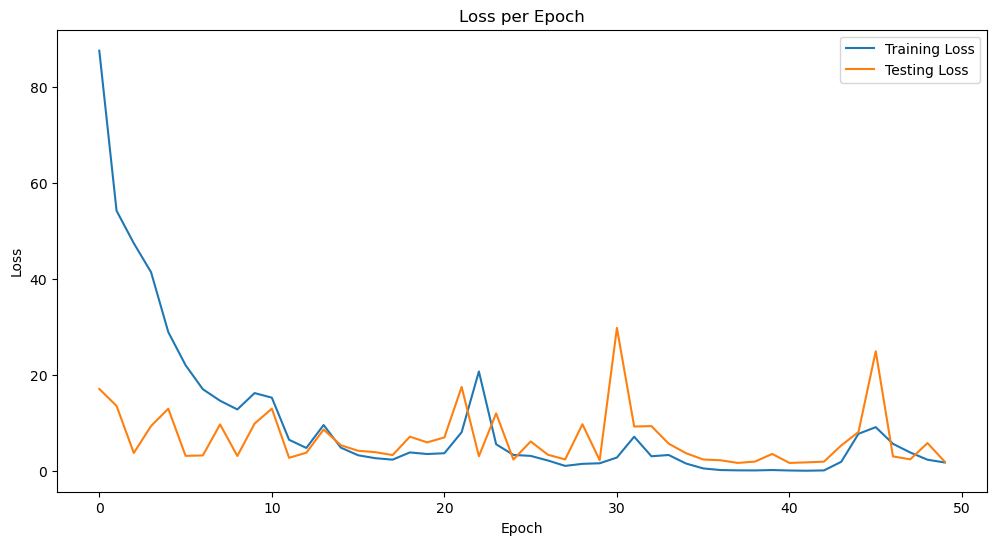

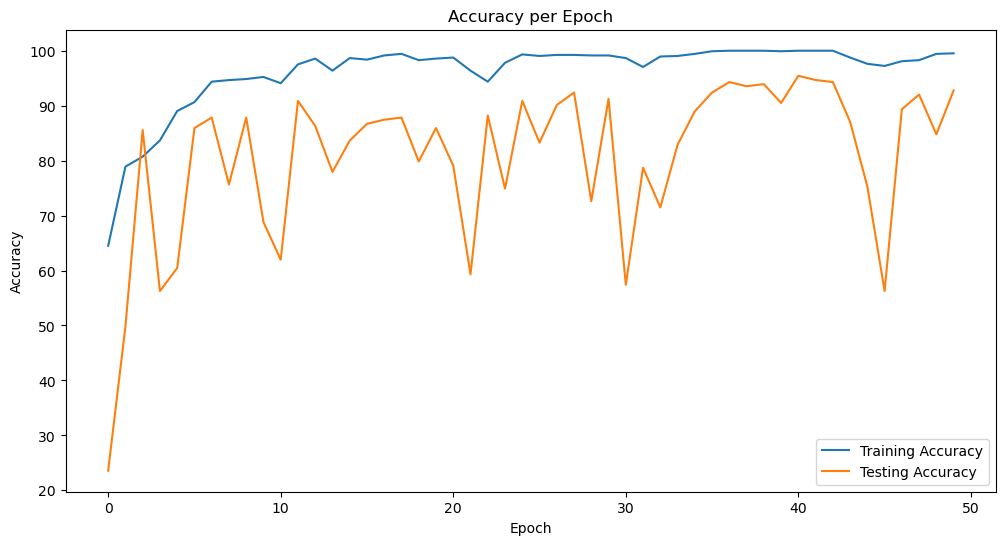

In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm

# Hyperparameters
in_channels = 1
num_classes = 4
learning_rate = 3e-4 # karpathy's constant
batch_size = 64
num_epochs = 50

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)  # Should print "cuda" if a GPU is available

model1 = GoogLeNet(num_classes=num_classes).to(device=device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10, verbose=True)

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    mri_dataset.mode = 'train'
    model1.train()
    losses = []
    loop = tqdm(enumerate(train_dataloader), total=len(train_dataloader))
    whole_loss = 0
    correct_predictions = 0
    total_predictions = 0
    for batch_idx, sample in loop:
        data = sample['image']
        targets = sample['label'].long()
        data = data.unsqueeze(1)
        data = data.to(device=device)
        targets = targets.to(device=device)
        # forward
        outputs = model1(data, True)
        if isinstance(outputs, tuple):
            loss1 = criterion(outputs[0], targets)
            loss2 = criterion(outputs[1], targets)
            loss3 = criterion(outputs[2], targets)
            loss = loss1 + loss2 + loss3
        else:
            loss = criterion(outputs, targets)
        losses.append(loss.item())
        whole_loss += abs(loss.item())
        _, predicted = torch.max(outputs[2], 1)
        total_predictions += targets.size(0)
        correct_predictions += (predicted == targets).sum().item()
        accuracy = 100.0 * correct_predictions / total_predictions
        # backward
        optimizer.zero_grad()
        loss.backward()
        # gradient descent or adam step
        optimizer.step()
        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
        loop.set_postfix(loss=whole_loss, acc=accuracy)
    mean_loss = sum(losses) / len(losses)
    mean_loss = round(mean_loss, 2)
    scheduler.step(mean_loss)
    train_losses.append(whole_loss)
    train_accuracies.append(accuracy)

    # Testing phase
    mri_dataset.mode = 'val'
    model1.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for D in test_dataloader:
            data = D['image']
            data = data.unsqueeze(1).to(device=device)
            targets = D['label'].to(device=device).long()
            outputs = model1(data, True)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    test_losses.append(test_loss)
    test_accuracies.append(100.0 * correct / total)
    print(f"Test Loss: {test_loss}, Test Accuracy: {100.0 * correct / total}")

# Plot training and testing loss
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and testing accuracy
plt.figure(figsize=(12, 6))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Testing Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Accuracy: 0.9543726235741445
F1 Score: 0.9547433022580597
Recall: 0.9543726235741445
Precision: 0.9566154717329591


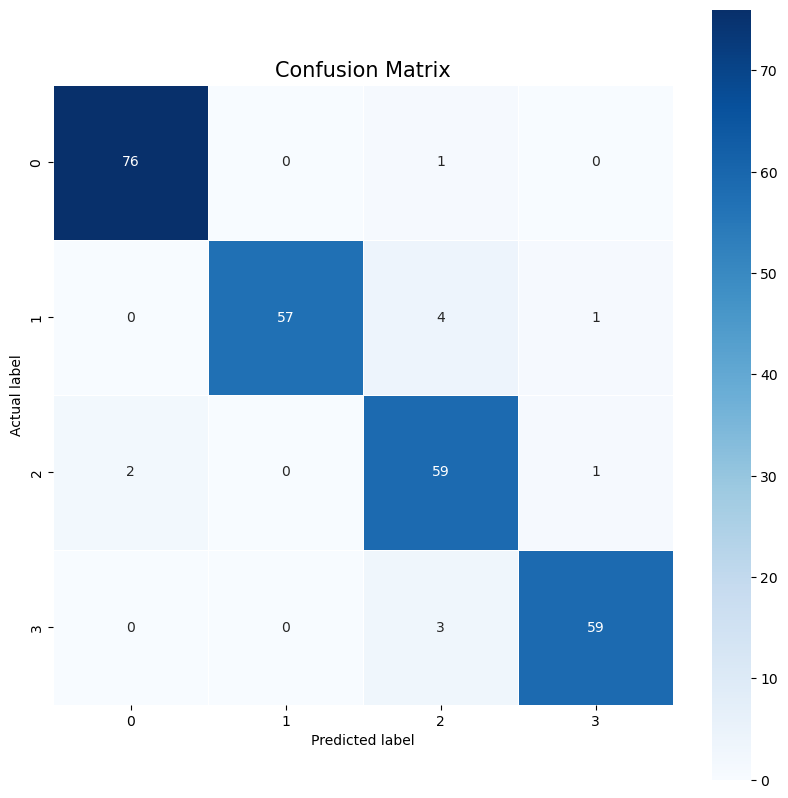

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming that test_dataloader is your test data loader
model.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for D in test_dataloader:
        data = D['image']
        data = data.unsqueeze(1).to(device=device)
        targets = D['label'].to(device=device)
        outputs = model(data, True)
        _, predictions = outputs.max(1)
        all_preds.extend(predictions.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(all_targets, all_preds)
f1score = f1_score(all_targets, all_preds, average='weighted')
recall = recall_score(all_targets, all_preds, average='weighted')
precision = precision_score(all_targets, all_preds, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1score}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")

# Plot confusion matrix
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square=True, cmap='Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix', size=15)
plt.show()
